# Exploration data analysis of the historical supermarket customer data

## Define the function to concate the full data and preprocess

In [17]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt 

In [16]:


def  prepro_data(filepath):
    import os
    # list all the files in the folder
    f=os.listdir(filepath)
    dff=pd.DataFrame(columns=['timestamp', 'location', 'customer_id'])
    for i in f:
        df=pd.read_csv(f'./data/{i}',delimiter=';',parse_dates=True)
        #change timestamp to datatime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        #set timestamp as index
        df.set_index('timestamp',drop=True, inplace=True)
        df['day']=df.index.day
        #change data type of customer_no
        df[['customer_no','day']]=df[['customer_no','day']].astype('string')
        #generate uni customer_id for every customer in 5 days.
        df['customer_id']=df['day']+df['customer_no']
        df.drop(['customer_no','day'],axis=1, inplace =True)
        df.reset_index(inplace=True)
        dff=pd.concat([dff,df])
    dff.set_index('timestamp',drop=True, inplace=True)
    return dff

In [5]:
#concate the full data and preprocess

filepath = './data/'
df=prepro_data(filepath)

In [7]:
#add new columns 'hour', 'day'
df['day']=df.index.day
df['hour']=df.index.hour

## Calculate the total number of customers in each section

In [8]:

#example of groupby function: df.groupby("Sex").agg({"Survived":np.sum, "Age":np.mean, "Fare":np.mean})
#task 1 method a)
df_g_l=df.groupby('location')['day','hour','customer_id'].count()

<ipython-input-8-e6aa90f2d49d>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_g_l=df.groupby('location')['day','hour','customer_id'].count()


In [10]:
df_g_l



,day,hour,customer_id
location,,,
checkout,7417,7417,7417
dairy,4679,4679,4679
drinks,3905,3905,3905
fruit,5122,5122,5122
spices,3754,3754,3754


##  Show the total number of customers in each section over time

In [15]:
df_g_l_t=df.groupby(['location','hour'])['customer_id','day'].count()

<ipython-input-15-ff5dee84fe6f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_g_l_t=df.groupby(['location','hour'])['customer_id','day'].count()


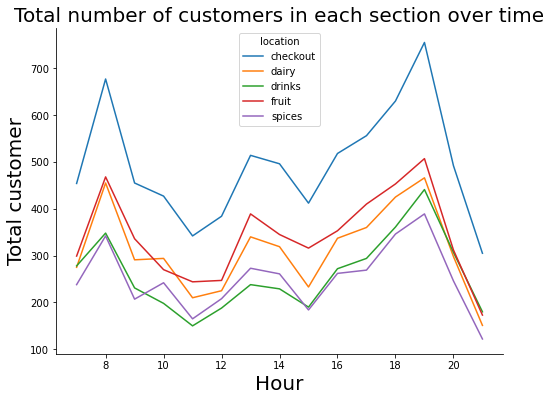

In [18]:

#from matplotlib.pyplot import figure

fig, ax=plt.subplots(figsize=(8, 6))

# fig = plt.figure(figsize=(8, 6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Hour', fontsize=20)
plt.ylabel('Total customer', fontsize=20)



#figure(figsize=(12, 10), dpi=80)
plt.title('Total number of customers in each section over time',fontsize=20)

sns.lineplot(x='hour',y='customer_id',hue='location',data=df_g_l_t)
#plt.axis('off')
plt.show()

## Plot total number of customers in the supermarket over time

Text(0.5, 1.0, 'Total number of customers in supermarket over time')

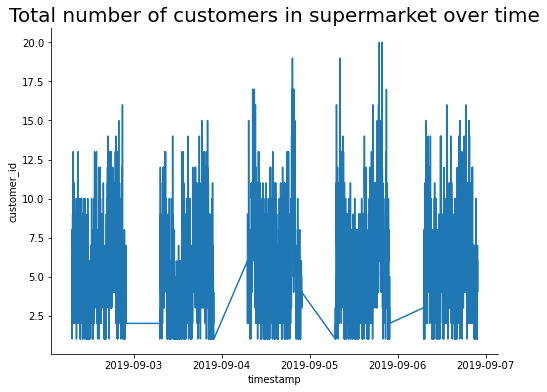

In [22]:
df_subset=df.groupby(df.index)['customer_id'].count()
df_subset=pd.DataFrame(df_subset)
#plot the picture
fig, ax=plt.subplots(figsize=(8, 6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.lineplot(x='timestamp',y='customer_id', data=df_subset)
plt.title('Total number of customers in supermarket over time',fontsize=20)

## calculation the transition probablity

In [24]:
# resample changes the index - same as groupby
# but we have to add an operation - same as groupby
df_full = df.groupby('customer_id').resample('1min').fillna('ffill')
df_full

location customer_id  day  hour
customer_id timestamp                                           
21          2019-09-02 07:03:00     dairy          21    2     7
            2019-09-02 07:04:00     dairy          21    2     7
            2019-09-02 07:05:00  checkout          21    2     7
210         2019-09-02 07:06:00     fruit         210    2     7
            2019-09-02 07:07:00     fruit         210    2     7
...                                   ...         ...  ...   ...
6999        2019-09-06 17:23:00     fruit        6999    6    17
            2019-09-06 17:24:00    drinks        6999    6    17
            2019-09-06 17:25:00     fruit        6999    6    17
            2019-09-06 17:26:00     fruit        6999    6    17
            2019-09-06 17:27:00  checkout        6999    6    17

[53903 rows x 4 columns]

In [26]:
df_full['after'] = df_full['location'].shift(-1)
# there is time overlap between customers, but this problem is solved with ct_pro['checkout'] = [1.0, 0.0, 0.0, 0.0, 0.0]

In [27]:
pd.crosstab(df_full['after'], df_full['location'])#.to_csv('crosstab.csv') # counts

location,checkout,dairy,drinks,fruit,spices
after,,,,,
checkout,0,1825,2096,2555,941
dairy,2132,13100,107,1219,1215
drinks,1137,1042,5821,702,1024
fruit,2801,890,856,7588,573
spices,1346,917,846,644,2525


In [29]:
ct_pro= pd.crosstab(df_full['after'], df_full['location'], normalize=1) # try 0 and 1

ct_pro['checkout'] = [1.0, 0.0, 0.0, 0.0, 0.0]
# make sure that for each 'before' state the numbers sum up to 1.0

In [34]:
ct_pro.to_csv('./tr_prob.csv')